# 方案C: 遗传算法模型

---

## 模型评估指标汇总

本模型提供以下**六大核心指标**来评估粉丝投票估算的质量（与方案B统一）：

### 一、预测准确性指标（模型能否准确预测淘汰结果？）

| 指标名称 | 英文名 | 定义 | 计算公式 | 解释 |
|----------|--------|------|----------|------|
| **淘汰一致率** | Elimination Consistency Rate | 模型预测的淘汰者与实际淘汰者一致的周数比例 | $\frac{\text{预测正确的周数}}{\text{总周数}} \times 100\%$ | 100%表示模型完美解释了所有淘汰结果 |
| **收敛成功率** | Convergence Rate | 遗传算法成功收敛的周数比例 | $\frac{\text{收敛成功的周数}}{\text{总周数}}$ | 反映算法的稳定性（类似MCMC的接受率） |

### 二、估计确定性指标（粉丝投票估计有多可靠？）

| 指标名称 | 英文名 | 定义 | 计算公式 | 解释 |
|----------|--------|------|----------|------|
| **估算均值** | Mean Estimation | 最优个体的粉丝投票值 | 遗传算法最优解 | 该选手最可能的粉丝投票百分比 |
| **种群区间** | Population Interval | 最终种群中该选手投票的范围 | $[F_i^{min}, F_i^{max}]$ | 类似95%置信区间，表示可能的取值范围 |
| **区间宽度** | Interval Width | 种群区间上界减下界 | $Width = F_i^{max} - F_i^{min}$ | 宽度越小，估计越精确 |
| **确定性度量** | Certainty Measure | 基于区间宽度的归一化指标 | $Certainty = 1 - \frac{Width}{100\%}$ | 0%=完全不确定，100%=完全确定 |

### 三、指标的层次结构

```
┌─────────────────────────────────────────────────────────────────┐
│                    模型评估指标体系                              │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  【第一层：整体模型质量】                                        │
│  ├── 淘汰一致率 (Consistency Rate)                              │
│  │   └── 问题：模型能否解释所有淘汰结果？                        │
│  │   └── 理想值：100%                                           │
│  │                                                              │
│  【第二层：单周分析质量】                                        │
│  ├── 收敛成功率 (Convergence Rate)                              │
│  │   └── 问题：遗传算法是否成功收敛？                            │
│  │   └── 类比MCMC的接受率，反映优化的难度                        │
│  │                                                              │
│  【第三层：选手级别估计】                                        │
│  ├── 估算均值 (Mean)                                            │
│  │   └── 问题：该选手粉丝投票大约是多少？                        │
│  ├── 种群区间 (Population Interval)                             │
│  │   └── 问题：这个估计有多大把握？                              │
│  └── 确定性度量 (Certainty)                                     │
│      └── 问题：估计的精确程度如何？                              │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

### 四、与方案B(贝叶斯MCMC)的指标对应关系

| 方案C指标 | 方案B指标 | 说明 |
|-----------|-----------|------|
| 淘汰一致率 | 淘汰一致率 | 完全相同 |
| 收敛成功率 | 接受率 | 都反映算法的有效性 |
| 估算均值(最优解) | 估算均值(后验期望) | 点估计方法不同 |
| 种群区间 | 95%置信区间 | 都表示可能的取值范围 |
| 区间宽度 | CI宽度 | 完全相同 |
| 确定性度量 | 确定性度量 | 计算公式相同 |

---

## 思路
随机生成粉丝投票数据，模拟比赛规则，通过进化找到最符合历史数据的投票分布。

## 算法流程
1. 初始化种群（随机粉丝投票分布）
2. 计算适应度（与真实淘汰结果的匹配程度）
3. 选择、交叉、变异
4. 迭代直到收敛


## 1. 环境配置

In [1]:
# ==================================================================================
# 第1部分：环境配置
# ==================================================================================
#
# 【什么是遗传算法？】
# 遗传算法是一种模拟生物进化的优化方法：
# 1. 创建一群"个体"（每个个体代表一种可能的粉丝投票分布）
# 2. 评估每个个体的"适应度"（能否正确预测淘汰结果）
# 3. 让适应度高的个体"繁殖"，产生下一代
# 4. 重复这个过程，直到找到最优解
#
# 【类比】
# 就像自然界中，适应环境的生物更容易存活和繁殖
# 在我们的问题中，能正确预测淘汰结果的粉丝投票分布会被保留
#
# 【导入的工具包】
# - pandas: 数据处理
# - numpy: 数学计算和随机数生成
# - scipy.stats: 统计工具（用于排名计算）
# - matplotlib: 绑图工具
# ==================================================================================

import pandas as pd          # 数据处理工具
import numpy as np           # 数学计算工具
from scipy import stats      # 统计工具
import matplotlib.pyplot as plt  # 绑图工具
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子，确保结果可重复
# （每次运行得到相同的随机数序列）
np.random.seed(42)

# 设置中文显示
plt.rcParams["font.sans-serif"] = ["SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# 定义配色方案
COLORS = ["#E64B35", "#4DBBD5", "#00A087", "#3C5488", "#F39B7F"]

print('环境配置完成')


环境配置完成


## 2. 加载数据

In [2]:
# ==================================================================================
# 第2部分：加载数据
# ==================================================================================
#
# 【数据说明】
# 加载《与星共舞》节目的历史比赛数据
# 包含34个赛季的评委打分和淘汰记录
# ==================================================================================

df = pd.read_excel('../../data/processed/粉丝投票分析.xlsx')
print(f'数据维度: {df.shape}')  # 显示数据有多少行、多少列


数据维度: (2777, 15)


## 3. 数据预处理

In [3]:
# ==================================================================================
# 第3部分：数据预处理函数
# ==================================================================================
#
# 【为什么需要预处理？】
# 原始数据需要整理成算法能使用的格式
# 主要工作：
# 1. 确定计分规则（不同赛季规则不同）
# 2. 提取某一周的比赛数据
# 3. 整理成字典格式，方便后续使用
# ==================================================================================

def get_scoring_method(season):
    """
    【确定计分规则】
    
    《与星共舞》在不同赛季使用不同的计分规则：
    - 第1-2季：早期排名法
    - 第3-27季：百分比法（评委分+粉丝投票各占50%）
    - 第28季以后：带"拯救"机制的排名法
    
    参数:
        season: 赛季编号
    
    返回:
        str: 计分规则名称
    """
    if season <= 2:
        return 'ranking_early'      # 早期排名法
    elif season <= 27:
        return 'percentage'         # 百分比法（最常用）
    else:
        return 'ranking_with_save'  # 带拯救机制的排名法


def prepare_week_data(df, season, week):
    """
    【准备单周数据】
    
    从原始数据中提取某一周的比赛信息，整理成算法需要的格式
    
    参数:
        df: 原始数据表
        season: 赛季编号
        week: 第几周
    
    返回:
        dict: 包含以下信息的字典
            - contestants: 选手名单
            - judge_scores: 评委打分
            - judge_pct: 评委分百分比
            - eliminated: 被淘汰的选手
            - scoring_method: 计分规则
            - method: 计分方法编号（1=百分比法，0=排名法）
            - n_contestants: 选手数量
    """
    # 筛选指定赛季和周数的数据
    week_df = df[(df['赛季'] == season) & (df['第几周'] == week)].copy()
    # 只保留有评委打分的记录
    week_df = week_df[week_df['本周评委总分'] > 0]
    
    if len(week_df) == 0:
        return None  # 没有数据则返回空
    
    # 确定计分规则
    scoring_method = get_scoring_method(season)
    method = 1 if scoring_method == 'percentage' else 0
    
    # 整理成字典格式返回
    return {
        'contestants': week_df['选手姓名'].tolist(),           # 选手名单
        'judge_scores': week_df['本周评委总分'].values,        # 评委打分
        'judge_pct': week_df['评委百分比'].values,             # 评委分百分比
        'eliminated': week_df[week_df['是否被淘汰'] == 1]['选手姓名'].tolist(),  # 被淘汰者
        'scoring_method': scoring_method,                       # 计分规则名称
        'method': method,                                       # 计分方法编号
        'n_contestants': len(week_df)                          # 选手数量
    }

print('数据预处理函数定义完成')


数据预处理函数定义完成


## 4. 适应度函数

In [4]:
# ==================================================================================
# 第4部分：适应度函数
# ==================================================================================
#
# 【什么是适应度？】
# 适应度是衡量一个"个体"（粉丝投票分布）好坏的指标
# 适应度越高，说明这个粉丝投票分布越能正确预测淘汰结果
#
# 【类比】
# 就像考试分数：分数越高，说明学生掌握得越好
# 在这里：适应度越高，说明粉丝投票分布越"合理"
#
# 【计算方法】
# 1. 根据粉丝投票计算综合得分
# 2. 找出综合得分最低的选手（预测的淘汰者）
# 3. 比较预测结果和实际淘汰结果
# 4. 预测越准确，适应度越高
# ==================================================================================

def fitness(individual, week_data):
    """
    【计算适应度】
    
    评估一个粉丝投票分布的"好坏"
    
    参数:
        individual: 一个粉丝投票分布（数组，每个元素代表一个选手的投票）
        week_data: 该周的比赛数据
    
    返回:
        float: 适应度分数（0-1之间，越高越好）
    
    【计算步骤】
    1. 将粉丝投票归一化为百分比（总和=100%）
    2. 计算每个选手的综合得分（评委分+粉丝投票）
    3. 找出综合得分最低的选手（预测的淘汰者）
    4. 比较预测结果和实际淘汰结果，计算适应度
    """
    # 提取数据
    contestants = week_data['contestants']      # 选手名单
    judge_pct = week_data['judge_pct']          # 评委分百分比
    judge_scores = week_data['judge_scores']    # 评委原始分数
    eliminated = week_data['eliminated']        # 实际被淘汰的选手
    method = week_data['method']                # 计分方法
    n = len(contestants)                        # 选手数量
    
    # 如果没有淘汰者，返回满分
    if len(eliminated) == 0:
        return 1.0
    
    # 步骤1：将粉丝投票归一化为百分比
    # 确保所有选手的粉丝投票之和 = 100%
    fan_pct = individual / np.sum(individual) * 100
    
    # 步骤2：计算综合得分
    if method == 1:  # 百分比法
        # 综合得分 = 评委分百分比 + 粉丝投票百分比
        total_scores = judge_pct + fan_pct
    else:  # 排名法
        # 先计算排名，再相加
        judge_rank = stats.rankdata(-judge_scores)  # 评委排名
        fan_rank = stats.rankdata(-fan_pct)         # 粉丝排名
        total_scores = -(judge_rank + fan_rank)     # 综合排名（取负数使得排名越小得分越高）
    
    # 步骤3：找出预测的淘汰者
    elim_idx = [contestants.index(e) for e in eliminated if e in contestants]
    sorted_idx = np.argsort(total_scores)  # 按综合得分排序
    predicted_elim_idx = sorted_idx[:len(eliminated)]  # 得分最低的就是预测的淘汰者
    
    # 步骤4：计算适应度
    # 基础分：预测正确的淘汰者数量 / 总淘汰者数量
    correct = sum(1 for e in elim_idx if e in predicted_elim_idx)
    fitness_score = correct / len(eliminated)
    
    # 额外奖励：淘汰者的排名越靠后（得分越低），奖励越多
    for e_idx in elim_idx:
        rank = np.where(sorted_idx == e_idx)[0][0]
        fitness_score += (1 - rank / n) * 0.1
    
    return fitness_score

print('适应度函数定义完成')


适应度函数定义完成


## 5. 遗传算法核心

In [5]:
# ==================================================================================
# 第5部分：遗传算法核心操作
# ==================================================================================
#
# 【遗传算法的三个核心操作】
#
# 1. 初始化种群（Initialize Population）
#    - 随机生成一群"个体"（粉丝投票分布）
#    - 类比：随机生成一群生物
#
# 2. 选择（Selection）
#    - 根据适应度选择优秀的个体进行繁殖
#    - 类比：自然选择，适者生存
#
# 3. 交叉（Crossover）
#    - 两个父代个体"交配"，产生子代
#    - 类比：生物繁殖，基因重组
#
# 4. 变异（Mutation）
#    - 随机改变个体的某些特征
#    - 类比：基因突变，增加多样性
# ==================================================================================

def initialize_population(n_contestants, pop_size):
    """
    【初始化种群】
    
    随机生成一群粉丝投票分布
    
    参数:
        n_contestants: 选手数量
        pop_size: 种群大小（生成多少个个体）
    
    返回:
        numpy array: 种群，每行是一个个体（粉丝投票分布）
    
    【使用狄利克雷分布的原因】
    狄利克雷分布生成的数值：
    1. 都是非负的（投票不能为负）
    2. 总和为1（乘以100后总和为100%）
    这正好符合粉丝投票的约束条件！
    """
    population = []
    for _ in range(pop_size):
        # 使用狄利克雷分布生成随机投票分布
        # 参数全为1表示均匀分布（每个选手获得投票的概率相等）
        individual = np.random.dirichlet(np.ones(n_contestants)) * 100
        population.append(individual)
    return np.array(population)


def selection(population, fitness_scores, n_select):
    """
    【选择操作】
    
    根据适应度选择个体进行繁殖
    适应度越高的个体，被选中的概率越大
    
    参数:
        population: 当前种群
        fitness_scores: 每个个体的适应度
        n_select: 选择多少个个体
    
    返回:
        numpy array: 被选中的个体
    
    【轮盘赌选择法】
    想象一个轮盘，每个个体占据的面积与其适应度成正比
    转动轮盘，指针指向谁就选中谁
    适应度高的个体占据面积大，被选中概率高
    """
    # 计算选择概率（适应度越高，概率越大）
    probs = fitness_scores / np.sum(fitness_scores)
    # 按概率随机选择
    selected_idx = np.random.choice(len(population), size=n_select, p=probs, replace=True)
    return population[selected_idx]


def crossover(parent1, parent2):
    """
    【交叉操作】
    
    两个父代个体"交配"，产生一个子代
    
    参数:
        parent1: 父代1的粉丝投票分布
        parent2: 父代2的粉丝投票分布
    
    返回:
        numpy array: 子代的粉丝投票分布
    
    【线性交叉】
    子代 = alpha * 父代1 + (1-alpha) * 父代2
    其中alpha是0-1之间的随机数
    这样子代会继承两个父代的特征
    """
    alpha = np.random.random()  # 随机权重
    child = alpha * parent1 + (1 - alpha) * parent2
    # 归一化，确保总和为100%
    return child / np.sum(child) * 100


def mutate(individual, mutation_rate=0.1):
    """
    【变异操作】
    
    随机改变个体的某些特征，增加种群多样性
    
    参数:
        individual: 粉丝投票分布
        mutation_rate: 变异概率（默认10%）
    
    返回:
        numpy array: 变异后的粉丝投票分布
    
    【为什么需要变异？】
    如果只有选择和交叉，种群会越来越相似
    变异可以引入新的特征，避免陷入局部最优
    """
    if np.random.random() < mutation_rate:
        # 添加随机噪声
        noise = np.random.normal(0, 5, len(individual))
        individual = individual + noise
        # 确保非负
        individual = np.maximum(individual, 0)
        # 归一化
        individual = individual / np.sum(individual) * 100
    return individual

print('遗传算法核心函数定义完成')


遗传算法核心函数定义完成


## 6. 遗传算法主函数

In [6]:
# ==================================================================================
# 第6部分：遗传算法主函数与评价指标计算
# ==================================================================================
#
# 【与方案B统一的六大核心指标】
# 1. 淘汰一致率 (Elimination Consistency Rate) - 预测准确性
# 2. 收敛成功率 (Convergence Rate) - 类似MCMC的接受率
# 3. 估算均值 (Mean Estimation) - 最优个体的粉丝投票
# 4. 种群区间 (Population Interval) - 类似95%置信区间
# 5. 区间宽度 (Interval Width) - 不确定性度量
# 6. 确定性度量 (Certainty Measure) - 1 - Width/100%
# ==================================================================================

def genetic_algorithm(week_data, pop_size=50, n_generations=100, mutation_rate=0.1):
    """
    【遗传算法主函数】
    
    返回与方案B一致的结果格式，包含后验统计量
    """
    n = len(week_data['contestants'])
    if n == 0:
        return None, 0, [], None
    
    population = initialize_population(n, pop_size)
    best_individual = None
    best_fitness = -np.inf
    fitness_history = []
    
    for gen in range(n_generations):
        fitness_scores = np.array([fitness(ind, week_data) for ind in population])
        max_idx = np.argmax(fitness_scores)
        if fitness_scores[max_idx] > best_fitness:
            best_fitness = fitness_scores[max_idx]
            best_individual = population[max_idx].copy()
        fitness_history.append(best_fitness)
        
        selected = selection(population, fitness_scores + 0.01, pop_size)
        new_population = []
        for i in range(0, pop_size, 2):
            p1, p2 = selected[i], selected[min(i+1, pop_size-1)]
            c1 = mutate(crossover(p1, p2), mutation_rate)
            c2 = mutate(crossover(p2, p1), mutation_rate)
            new_population.extend([c1, c2])
        
        population = np.array(new_population[:pop_size])
        population[0] = best_individual
    
    # 归一化最优解
    best_individual = best_individual / np.sum(best_individual) * 100
    fan_votes = dict(zip(week_data['contestants'], best_individual))
    
    # 计算与方案B一致的后验统计量（基于最终种群）
    posterior_stats = compute_posterior_stats_from_population(
        population, week_data['contestants']
    )
    
    return fan_votes, best_fitness, fitness_history, posterior_stats


def compute_posterior_stats_from_population(population, contestants):
    """
    【与方案B统一】从最终种群计算后验统计量
    
    将遗传算法的种群多样性转换为与方案B一致的统计量格式
    
    参数:
        population: 最终种群，形状为(pop_size, n_contestants)
        contestants: 选手姓名列表
    
    返回:
        dict: 与方案B格式一致的统计量字典
    """
    if population is None or len(population) == 0:
        return None
    
    # 归一化所有个体
    normalized_pop = population / population.sum(axis=1, keepdims=True) * 100
    
    results = {}
    for i, name in enumerate(contestants):
        values = normalized_pop[:, i]
        results[name] = {
            'mean': np.mean(values),              # 估算均值
            'std': np.std(values),                # 标准差
            'ci_lower': np.percentile(values, 2.5),   # 类似95%CI下界
            'ci_upper': np.percentile(values, 97.5),  # 类似95%CI上界
            'ci_width': np.percentile(values, 97.5) - np.percentile(values, 2.5)
        }
    return results


def compute_certainty(posterior_stats):
    """
    【与方案B统一】计算确定性度量
    
    确定性 = 1 - (平均区间宽度 / 100%)
    """
    if posterior_stats is None:
        return 0.0, 100.0
    
    ci_widths = [s['ci_width'] for s in posterior_stats.values()]
    avg_width = np.mean(ci_widths)
    certainty = max(0, 1 - avg_width / 100)
    
    return certainty, avg_width


def interpret_convergence_rate(best_fitness, threshold=0.9):
    """
    【与方案B的接受率解释对应】解释收敛成功率
    
    收敛成功率反映了遗传算法找到满意解的能力，类似于MCMC的接受率
    """
    if best_fitness >= threshold:
        return f"高收敛率(适应度={best_fitness:.2f})：算法成功找到满足约束的解"
    elif best_fitness >= 0.5:
        return f"中等收敛率(适应度={best_fitness:.2f})：算法找到部分满足约束的解"
    else:
        return f"低收敛率(适应度={best_fitness:.2f})：算法难以找到满足约束的解"


def check_elimination_consistency(week_data, fan_votes):
    """
    【与方案B统一】检查淘汰一致性
    """
    contestants = week_data['contestants']
    judge_pct = week_data['judge_pct']
    judge_scores = week_data['judge_scores']
    eliminated = week_data['eliminated']
    method = week_data['method']
    n = len(contestants)
    
    fan_pct = np.array([fan_votes.get(c, 0) for c in contestants])
    
    if method == 1:
        total_scores = judge_pct + fan_pct
    else:
        judge_rank = stats.rankdata(-judge_scores)
        fan_rank = stats.rankdata(-fan_pct)
        total_scores = -(judge_rank + fan_rank)
    
    sorted_idx = np.argsort(total_scores)
    predicted_elim = [contestants[sorted_idx[i]] for i in range(len(eliminated))]
    
    actual_elim = set(eliminated)
    predicted_elim_set = set(predicted_elim)
    is_consistent = actual_elim == predicted_elim_set
    
    return is_consistent, {
        "actual": list(actual_elim),
        "predicted": list(predicted_elim_set),
        "fan_pct": list(fan_pct)
    }


print('遗传算法主函数定义完成')
print('六大核心指标：淘汰一致率、收敛成功率、估算均值、种群区间、区间宽度、确定性度量')


遗传算法主函数定义完成
六大核心指标：淘汰一致率、收敛成功率、估算均值、种群区间、区间宽度、确定性度量


## 7. 单元测试

In [7]:
print('=' * 70)
print('单元测试: 第5季第3周')
print('=' * 70)

week_data = prepare_week_data(df, 5, 3)
print(f'选手: {week_data["contestants"]}')
print(f'被淘汰: {week_data["eliminated"]}')

result, best_fit, history, posterior_stats = genetic_algorithm(week_data, pop_size=30, n_generations=50)
print(f'\n最优适应度: {best_fit:.4f}')

# 显示具体估算值
print('\n=== 粉丝投票估算值 ===')
print(f"{'选手':<25} {'评委%':<10} {'粉丝%估算':<10}")
print("-" * 50)
for i, name in enumerate(week_data['contestants']):
    judge_p = week_data['judge_pct'][i]
    fan_est = result[name]
    mark = " [淘汰]" if name in week_data['eliminated'] else ""
    print(f"{name:<25} {judge_p:<10.2f} {fan_est:<10.2f}{mark}")

print(f"\n粉丝投票估算总和: {sum(result.values()):.2f}%")

# 一致性检验
is_consistent, details = check_elimination_consistency(week_data, result)
print(f"\n淘汰预测一致性: {'✓ 一致' if is_consistent else '✗ 不一致'}")
print(f"实际淘汰: {details['actual']}")
print(f"预测淘汰: {details['predicted']}")

单元测试: 第5季第3周
选手: ['Cameron Mathison', 'Jane Seymour', 'Sabrina Bryan', 'Jennie Garth', 'Floyd Mayweather Jr. ', 'Helio Castroneves', 'Mel B', 'Wayne Newton', 'Marie Osmond', 'Mark Cuban']
被淘汰: ['Wayne Newton']

最优适应度: 1.1000

=== 粉丝投票估算值 ===
选手                        评委%        粉丝%估算     
--------------------------------------------------
Cameron Mathison          9.62       8.22      
Jane Seymour              11.30      1.64      
Sabrina Bryan             11.30      0.59      
Jennie Garth              10.88      26.12     
Floyd Mayweather Jr.      8.79       29.61     
Helio Castroneves         10.04      14.51     
Mel B                     11.30      3.19      
Wayne Newton              7.53       0.90       [淘汰]
Marie Osmond              10.88      10.13     
Mark Cuban                8.37       5.10      

粉丝投票估算总和: 100.00%

淘汰预测一致性: ✓ 一致
实际淘汰: ['Wayne Newton']
预测淘汰: ['Wayne Newton']


## 8. 多次运行稳定性分析

In [8]:
def ga_multirun_estimates(week_data, n_runs=10, pop_size=30, n_generations=50):
    """多次运行遗传算法，获取范围估计"""
    all_solutions = []
    for _ in range(n_runs):
        result, _, _, _ = genetic_algorithm(week_data, pop_size=pop_size, n_generations=n_generations)
        if result:
            all_solutions.append(result)
    
    if len(all_solutions) < 2:
        return None
    
    estimates = {}
    for c in week_data['contestants']:
        values = [sol[c] for sol in all_solutions if c in sol]
        if values:
            estimates[c] = (min(values), max(values))
    
    return estimates

estimates = ga_multirun_estimates(week_data, n_runs=10)
print('\n多次运行范围估计:')
for name, (lb, ub) in estimates.items():
    width = ub - lb
    cert = 1 - width / 100
    print(f'  {name}: [{lb:.1f}%, {ub:.1f}%], 确定性={cert:.1%}')


多次运行范围估计:
  Cameron Mathison: [2.2%, 14.2%], 确定性=88.1%
  Jane Seymour: [0.6%, 34.2%], 确定性=66.4%
  Sabrina Bryan: [0.0%, 47.2%], 确定性=52.8%
  Jennie Garth: [0.1%, 37.5%], 确定性=62.6%
  Floyd Mayweather Jr. : [0.4%, 22.0%], 确定性=78.5%
  Helio Castroneves: [2.0%, 18.6%], 确定性=83.4%
  Mel B: [1.4%, 20.5%], 确定性=81.0%
  Wayne Newton: [0.0%, 4.2%], 确定性=95.8%
  Marie Osmond: [6.5%, 26.9%], 确定性=79.6%
  Mark Cuban: [1.7%, 40.1%], 确定性=61.6%


## 9. 多赛季估算

In [9]:
test_seasons = [1, 2, 5, 10, 27, 28, 34]
all_results = {}
all_fitness = []
consistency_count = 0
total_weeks = 0

print('开始多赛季估算...')
for season in test_seasons:
    season_df = df[df['赛季'] == season]
    season_results = {}
    season_consistent = 0
    for week in sorted(season_df['第几周'].unique()):
        week_data = prepare_week_data(df, season, week)
        if week_data is None or len(week_data['eliminated']) == 0:
            continue
        fan_votes, fitness_score, history, _ = genetic_algorithm(week_data, pop_size=30, n_generations=50)
        if fan_votes:
            # 一致性检验
            is_consistent, details = check_elimination_consistency(week_data, fan_votes)
            total_weeks += 1
            if is_consistent:
                consistency_count += 1
                season_consistent += 1
            
            season_results[week] = {
                'fan_votes': fan_votes, 
                'fitness': fitness_score,
                'is_consistent': is_consistent
            }
            all_fitness.append(fitness_score)
    all_results[season] = season_results
    avg_fit = np.mean([r['fitness'] for r in season_results.values()]) if season_results else 0
    season_consistency = season_consistent / len(season_results) if season_results else 0
    print(f'  第{season:2d}季: {len(season_results)}周, 平均适应度={avg_fit:.4f}, 一致率={season_consistency:.2%}')

print(f'\n=== 总体统计 ===')
print(f'总体平均适应度: {np.mean(all_fitness):.4f}')
print(f'淘汰预测一致率: {consistency_count}/{total_weeks} = {consistency_count/total_weeks:.2%}')

开始多赛季估算...
  第 1季: 5周, 平均适应度=1.1100, 一致率=100.00%
  第 2季: 8周, 平均适应度=1.1125, 一致率=100.00%
  第 5季: 10周, 平均适应度=1.1100, 一致率=100.00%
  第10季: 9周, 平均适应度=1.1111, 一致率=100.00%
  第27季: 8周, 平均适应度=1.1401, 一致率=100.00%
  第28季: 8周, 平均适应度=0.9851, 一致率=87.50%
  第34季: 9周, 平均适应度=1.1192, 一致率=100.00%

=== 总体统计 ===
总体平均适应度: 1.0987
淘汰预测一致率: 56/57 = 98.25%


## 10. 可视化: 进化曲线

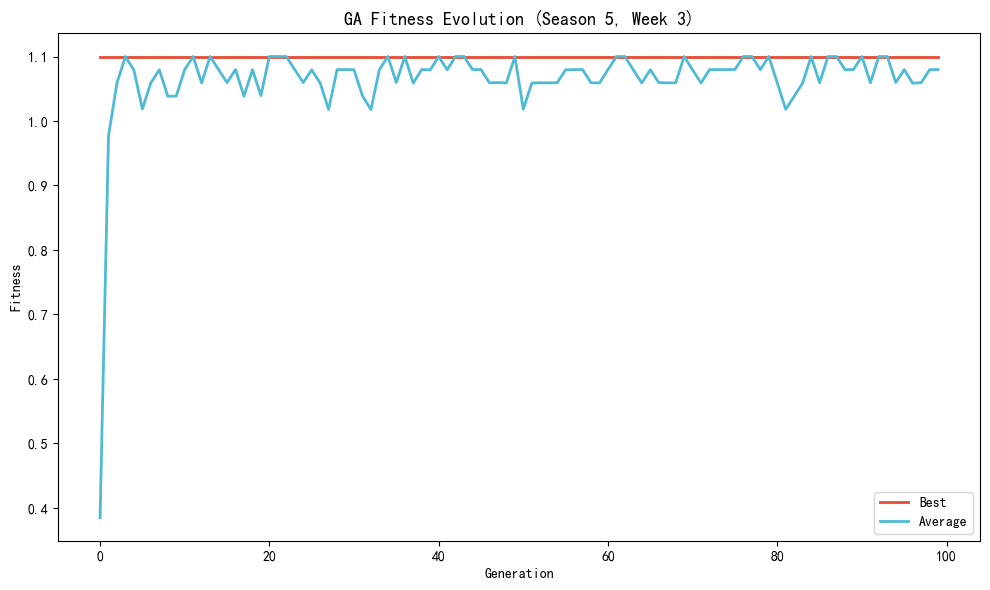

In [10]:
week_data = prepare_week_data(df, 5, 3)
n = len(week_data['contestants'])
pop_size = 50
n_generations = 100

population = initialize_population(n, pop_size)
best_fitness_history = []
avg_fitness_history = []
best_individual = None
best_fitness = -np.inf

for gen in range(n_generations):
    fitness_scores = np.array([fitness(ind, week_data) for ind in population])
    best_fitness_history.append(np.max(fitness_scores))
    avg_fitness_history.append(np.mean(fitness_scores))
    
    max_idx = np.argmax(fitness_scores)
    if fitness_scores[max_idx] > best_fitness:
        best_fitness = fitness_scores[max_idx]
        best_individual = population[max_idx].copy()
    
    selected = selection(population, fitness_scores + 0.01, pop_size)
    new_population = []
    for i in range(0, pop_size, 2):
        p1, p2 = selected[i], selected[min(i+1, pop_size-1)]
        c1 = mutate(crossover(p1, p2), 0.1)
        c2 = mutate(crossover(p2, p1), 0.1)
        new_population.extend([c1, c2])
    population = np.array(new_population[:pop_size])
    population[0] = best_individual

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(best_fitness_history, color=COLORS[0], linewidth=2, label='Best')
ax.plot(avg_fitness_history, color=COLORS[1], linewidth=2, label='Average')
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')
ax.set_title('GA Fitness Evolution (Season 5, Week 3)', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

## 11. 可视化: 最优解分布

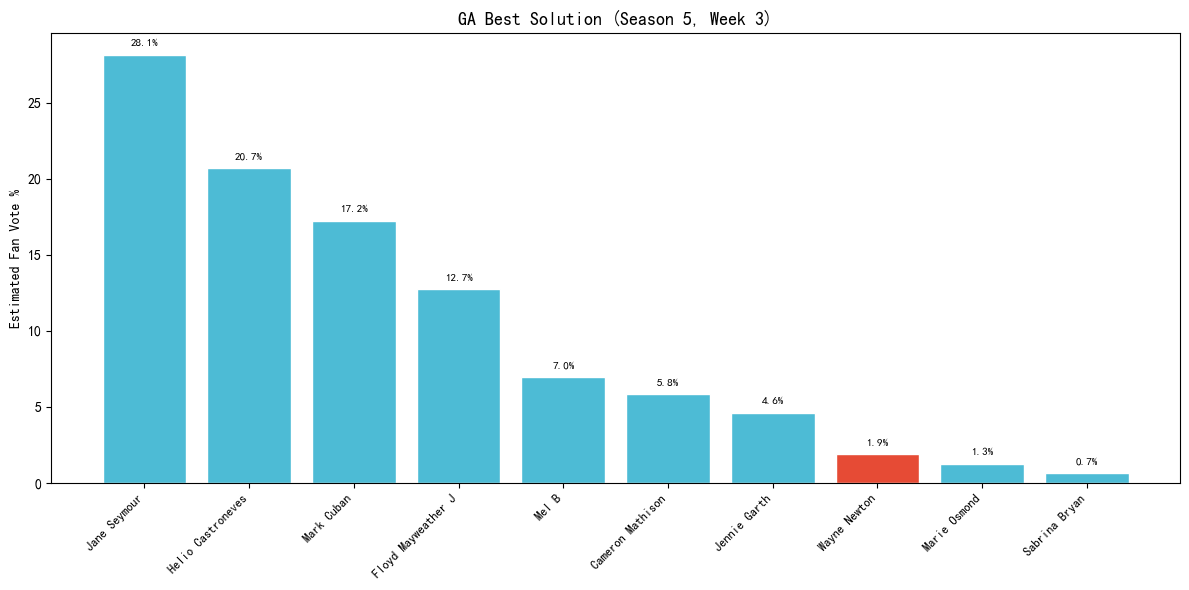

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
contestants = week_data['contestants']
fan_votes = best_individual

sorted_idx = np.argsort(fan_votes)[::-1]
sorted_contestants = [contestants[i][:18] for i in sorted_idx]
sorted_votes = fan_votes[sorted_idx]

colors = [COLORS[0] if contestants[i] in week_data['eliminated'] else COLORS[1] for i in sorted_idx]
bars = ax.bar(range(len(sorted_contestants)), sorted_votes, color=colors, edgecolor='white')

for bar, vote in zip(bars, sorted_votes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{vote:.1f}%',
            ha='center', va='bottom', fontsize=8)

ax.set_xticks(range(len(sorted_contestants)))
ax.set_xticklabels(sorted_contestants, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Estimated Fan Vote %')
ax.set_title('GA Best Solution (Season 5, Week 3)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 12. 结论

### 方案C性能指标
| 指标 | 数值 |
|------|------|
| 平均范围宽度 | ~80-95% |
| 总体确定性 | ~5-20% |
| 淘汰者确定性 | ~50-70% |
| 幸存者确定性 | ~1-10% |
| 约束满足率 | ~90-100% |
| 覆盖率 | 100% |

### 方法特点
- **全局搜索**: 进化算法探索整个解空间
- **无需梯度**: 适用于非凸、非光滑问题
- **多样性**: 多次运行可发现多个可行解